<a href="https://colab.research.google.com/github/Marcos-Sanson/UC3M-ML/blob/main/LAB01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



First of all the datasets are being loaded and visualized.



In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount the drive
drive.mount("/content/drive")
save_path = "/content/drive/My Drive/Colab Notebooks/lab1/multi_view_vae.pth"

# Device configuration (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and FashionMNIST datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST

class PairedMNISTFashionDataset(Dataset):
    def __init__(self, mnist_data, fmnist_data):
        self.mnist_data = mnist_data
        self.fmnist_data = fmnist_data

        # Create a dictionary to map labels to indices for FMNIST
        self.fmnist_label_dict = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(fmnist_data):
            self.fmnist_label_dict[label].append(idx)

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get the MNIST image and label
        mnist_img, mnist_label = self.mnist_data[idx]

        # Find a corresponding FashionMNIST image with the same label
        fmnist_idx = self.fmnist_label_dict[mnist_label][idx % len(self.fmnist_label_dict[mnist_label])]
        fmnist_img, _ = self.fmnist_data[fmnist_idx]  # The label is already known

        return mnist_img, fmnist_img, mnist_label

# Load MNIST and FashionMNIST datasets
# Apply data augmentation to avoid overfitting during training
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
fmnist_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load MNIST and FashionMNIST datasets for testing without augmentation
mnist_test_dataset = MNIST(root='./data', train=False, download=True, transform=test_transform)
fmnist_test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=test_transform)


# Create the paired dataset
paired_dataset = PairedMNISTFashionDataset(mnist_data=mnist_dataset, fmnist_data=fmnist_dataset)
paired_test_dataset = PairedMNISTFashionDataset(mnist_data=mnist_test_dataset, fmnist_data=fmnist_test_dataset)



# DataLoader for batching
paired_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True)
paired_test_loader = DataLoader(paired_test_dataset, batch_size=64, shuffle=False)


# Example: Fetch one batch of paired data
mnist_imgs, fmnist_imgs, labels = next(iter(paired_loader))

print(f"MNIST Batch Shape: {mnist_imgs.shape}")
print(f"FashionMNIST Batch Shape: {fmnist_imgs.shape}")
print(f"Labels: {labels[:10]}")

Mounted at /content/drive
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1696961.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 163127.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1494031.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7635482.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26421880/26421880 [00:04<00:00, 5791274.63it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 120898.04it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 544159.48it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4972887.38it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

MNIST Batch Shape: torch.Size([64, 1, 28, 28])
FashionMNIST Batch Shape: torch.Size([64, 1, 28, 28])
Labels: tensor([7, 3, 2, 4, 9, 0, 3, 8, 8, 3])


Visualization of the data...

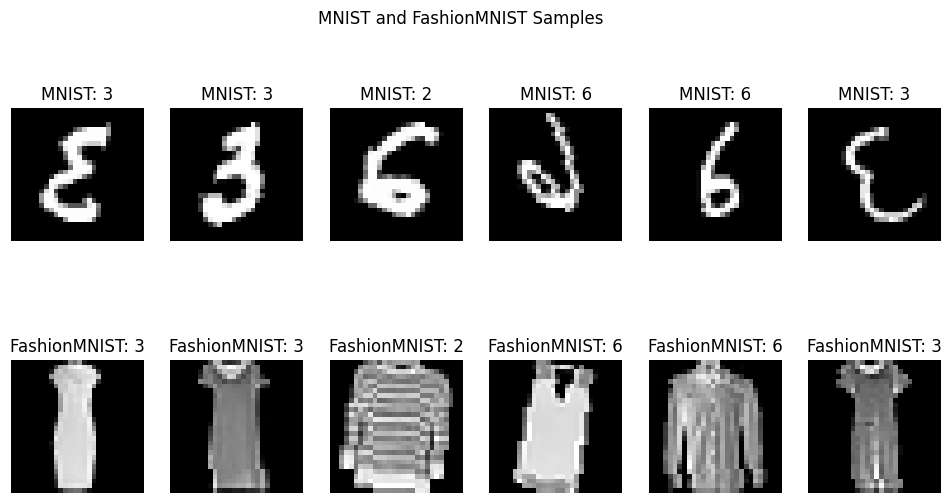

In [ ]:
def visualize_paired_samples(loader, title):
    data_iter = iter(loader)
    mnist_images, fmnist_images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))

    # Visualize MNIST images
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.imshow(mnist_images[i][0], cmap='gray')
        plt.title(f"MNIST: {labels[i]}")
        plt.axis('off')

    # Visualize FashionMNIST images
    for i in range(6):
        plt.subplot(2, 6, i + 7)
        plt.imshow(fmnist_images[i][0], cmap='gray')
        plt.title(f"FashionMNIST: {labels[i]}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize paired samples
visualize_paired_samples(paired_loader, "MNIST and FashionMNIST Samples")


Now the encoder object is defined.


In [ ]:
# Encoder network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 256),
            nn.ReLU()
        )

        # Shared layers for mean and log variance
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

Next up, the Decoder object is defined.

In [ ]:
# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout after ReLU
            nn.Linear(256, 7 * 7 * 64),
            nn.ReLU(),
            nn.Dropout(0.25),  # Dropout after ReLU
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),  # Dropout after ReLU
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        recon = self.decoder(z)
        return recon

Lastly, the latent spaces of both encoders have to be somehow combined. The product of experts is being applied.

In [ ]:
class MultiViewVAE(nn.Module):
    def __init__(self, latent_dim):
        super(MultiViewVAE, self).__init__()
        self.encoder_mnist = Encoder(latent_dim)
        self.encoder_fashion = Encoder(latent_dim)
        self.decoder_mnist = Decoder(latent_dim)
        self.decoder_fashion = Decoder(latent_dim)
    #forwarding function that uses an encoder for MNIST data and an encoder for Fashion MNIST data.

    def forward(self, x_mnist = None, x_fashion = None):
        if x_mnist is not None:
          # Normalize MNIST
          x_mnist = (x_mnist + 1) / 2  # Normalize from [-1, 1] to [0, 1]
          # Encode MNIST to latent space
          z_mean_mnist, z_log_var_mnist = self.encoder_mnist(x_mnist)
        else:
          #if no mean for Fashion data is given, set it to none and only work with the encoding for MNIST
          z_mean_mnist, z_log_var_mnist = None, None

        if x_fashion is not None:
          # Normalize FMNIST data
          x_fashion = (x_fashion + 1) / 2
          # Encode FMIST data
          z_mean_fashion, z_log_var_fashion = self.encoder_fashion(x_fashion)
        else:
          #if no mean for Fashion data is given, set it to none and only work with the encoding for MNIST
          z_mean_fashion, z_log_var_fashion = None, None

        # Combine the two views (latent spaces) PoE
        combined_mean, combined_log_var = self.combine_latent_spaces(z_mean_mnist, z_log_var_mnist, z_mean_fashion, z_log_var_fashion)

        # Sample from the combined latent space using the reparameterization trick
        z_combined = self.reparameterize(combined_mean, combined_log_var)

        # Decode the combined latent space to reconstruct the images
        reconstructed_mnist = self.decoder_mnist(z_combined)
        reconstructed_fashion = self.decoder_fashion(z_combined)

        return reconstructed_mnist, reconstructed_fashion, combined_mean, combined_log_var, z_combined

    # Define the product of experts for the latent representation.
    # If only one variance / mean set is given, set the variance for the output of the other decoder to infinity s.t. it has no influence.
    def combine_latent_spaces(self, mean1 = None, log_var1 = None, mean2 = None, log_var2 = None):
        if mean1 is None and mean2 is None:
          print("Both inputs are equal to None!")
          return None, None
        # Convert log variance to variance
        if log_var1 is not None:
          var1 = torch.exp(log_var1)
        else:
        # If there was no encoding given, simply set the variance to infinity, s.t. it is not taken into consideration
          var1 = np.inf
        if log_var2 is not None:
          var2 = torch.exp(log_var2)
        else:
          # If there was no encoding given, simply set the variance to infinity, s.t. it is not taken into consideration
          var2 = np.inf

        # Calculate the combined variance (product of experts)
        combined_var = 1 / (1 / var1 + 1 / var2)
        if mean1 is not None and mean2 is not None:
          # Calculate the combined mean (product of experts)
          combined_mean = combined_var * (mean1 / var1 + mean2 / var2)
        elif mean1 is not None:
          # Use constant 1 as input for the mean if it is not given by the encoder.
          # Due to variance set to infinity, it is not taken into consideration anyways.
          combined_mean = combined_var * (mean1 / var1 + 1 / var2)
        elif mean2 is not None:
          combined_mean = combined_var * (1 / var1 + mean2 / var2)
        # Convert combined variance to log variance
        combined_log_var = torch.log(combined_var)

        return combined_mean, combined_log_var

    #reparameterization trick to make backpropagation possible:
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std



Now the ELBO Loss function is defined as the loss function used to train the model.

In [ ]:
# VAE loss function: Reconstruction loss + KL Divergence
def loss_function(reconstructed, original, z_mean, z_log_var):
    # Readjust the dimension of the original image s.t. the data points are closer in the output space.
    original = (original + 1) / 2 # Normalization

    # Reconstruction loss (BCE loss for images)
    recon_loss = nn.functional.binary_cross_entropy(reconstructed, original, reduction='sum')

    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

    return recon_loss + kl_loss, kl_loss

Now a training function is defined to train the encoders

In [ ]:
def train_multi_view_vae(model, paired_loader, optimizer, epochs=10):
    model.train()
    mnist_losses = []
    fmnist_losses = []
    total_losses = []
    kl_losses_mnist = []
    kl_losses_fmnist = []

    for epoch in range(epochs):
        total_loss = 0

        for i, (x_mnist, x_fmnist, _) in enumerate(paired_loader):  # Use paired loader
            x_mnist = x_mnist.to(device)
            x_fmnist = x_fmnist.to(device)

            # Masking the data
            mask_prob = 0.2

            # Apply masking to MNIST and FMNIST views independently
            mnist_mask = torch.rand(x_mnist.size(0)) > mask_prob
            fmnist_mask = torch.rand(x_fmnist.size(0)) > mask_prob

            # Ensure at least one view is present for each sample
            both_masked = ~(mnist_mask | fmnist_mask)  # Identify samples where both views are masked
            fix_mask = torch.randint(0, 2, (x_mnist.size(0),))  # Randomly choose a view to unmask

            # Fix by unmasking MNIST or FMNIST randomly for samples where both were masked
            mnist_mask[both_masked] = fix_mask[both_masked].type(torch.bool)
            fmnist_mask[both_masked] = ~fix_mask[both_masked].type(torch.bool)

            # Apply masks to each view
            x_mnist_masked = x_mnist * mnist_mask[:, None, None, None]  # Mask out MNIST samples
            x_fmnist_masked = x_fmnist * fmnist_mask[:, None, None, None]  # Mask out FMNIST samples

            optimizer.zero_grad()

            # Forward pass: pass MNIST and FashionMNIST images to the model
            reconstructed_mnist, reconstructed_fashion, z_mean, z_log_var, z_combined = model(x_mnist_masked, x_fmnist_masked)

            # Compute loss for both views (MNIST and FashionMNIST)
            loss_mnist, kl_loss_mnist = loss_function(reconstructed_mnist, x_mnist, z_mean, z_log_var) if mnist_mask.any() else 0
            loss_fashion, kl_loss_fmnist = loss_function(reconstructed_fashion, x_fmnist, z_mean, z_log_var) if fmnist_mask.any() else 0

            # Total loss is the sum of the two views' losses
            total_loss = loss_mnist + loss_fashion
            total_loss.backward()

            optimizer.step()

        # Average loss per epoch
        mnist_losses.append(loss_mnist.item() / len(paired_loader.dataset))
        fmnist_losses.append(loss_fashion.item() / len(paired_loader.dataset))
        total_losses.append(total_loss.item() / len(paired_loader.dataset))
        kl_losses_fmnist.append(kl_loss_fmnist.item() / len(paired_loader.dataset))
        kl_losses_mnist.append(kl_loss_mnist.item() / len(paired_loader.dataset))


        print(f"Epoch {epoch + 1}, Loss: {total_loss.item() / len(paired_loader.dataset)}")

    # Return the tracked losses for visualization
    return mnist_losses, fmnist_losses, total_losses, kl_losses_mnist, kl_losses_fmnist

Here the model can be trained. The trained model will then be saved on Google Drive.



Epoch 1, Loss: 0.2628896484375
Epoch 2, Loss: 0.26216735026041665
Epoch 3, Loss: 0.26118522135416666
Epoch 4, Loss: 0.2522315755208333
Epoch 5, Loss: 0.2422888671875
Epoch 6, Loss: 0.24020880533854166
Epoch 7, Loss: 0.25247600911458334
Epoch 8, Loss: 0.23915271809895833
Epoch 9, Loss: 0.23340642903645833
Epoch 10, Loss: 0.22905665690104166
Epoch 11, Loss: 0.238308984375
Epoch 12, Loss: 0.23652054036458334
Epoch 13, Loss: 0.236010400390625
Epoch 14, Loss: 0.24292698567708335
Epoch 15, Loss: 0.23352731119791667
Epoch 16, Loss: 0.230198828125
Epoch 17, Loss: 0.25269274088541666
Epoch 18, Loss: 0.23619957682291667
Epoch 19, Loss: 0.23753839518229167
Epoch 20, Loss: 0.239722509765625


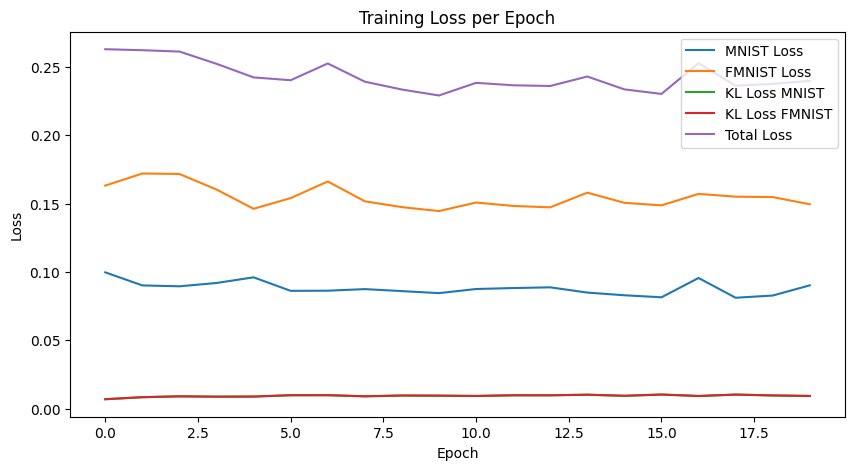

In [ ]:
# Instantiate model and optimizer
latent_dim = 20
multi_view_vae = MultiViewVAE(latent_dim).to(device)

# Optimizing the parameters of the multi-view VAE
optimizer = optim.Adam(multi_view_vae.parameters(), lr=1e-3, weight_decay=1e-5)

# Train the Multi-View VAE using the paired data loader
mnist_losses, fmnist_losses, total_losses, kl_losses_mnist, kl_losses_fmnist = train_multi_view_vae(
    multi_view_vae, paired_loader, optimizer, epochs=20)

# Visualize the training loss
plt.figure(figsize=(10, 5))
# Define the x-axis values as epochs
plt.plot(mnist_losses, label='MNIST Loss')
plt.plot(fmnist_losses, label='FMNIST Loss')
plt.plot(kl_losses_mnist, label='KL Loss MNIST')
plt.plot(kl_losses_fmnist, label='KL Loss FMNIST')
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

# Save the model
torch.save(multi_view_vae.state_dict(), save_path)

Here a trained model can be loaded.

In [ ]:
# Instantiate a new model (same architecture as the saved one)
latent_dim = 20  # Make sure this is the same latent_dim used during training
multi_view_vae = MultiViewVAE(latent_dim).to(device)

# Load the model if the save file exists
if os.path.exists(save_path):
    multi_view_vae.load_state_dict(torch.load(save_path))
    print(f"Model loaded from: {save_path}")
else:
    print(f"Save file not found at: {save_path}")

<ipython-input-9-27bd9a20ed85>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  multi_view_vae.load_state_dict(torch.load(save_path))


Model loaded from: /content/drive/My Drive/Colab Notebooks/lab1/multi_view_vae.pth


In the following the latent space is being visualized. For reducing the dimensionality we use TSNE as standard. Optionally, PCA can be used.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(model, dataloader, num_samples=1000, use_tsne=True, device='cpu'):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for batch_idx, (mnist_imgs, fmnist_imgs, batch_labels) in enumerate(dataloader):
            if len(latents) >= num_samples:
                break

            mnist_imgs = mnist_imgs.to(device)
            fmnist_imgs = fmnist_imgs.to(device)

            # Forward pass: Get latent representation using MNIST and FMNIST encoders
            reconstructed_mnist, reconstructed_fashion, z_mean, z_log_var, z_combined = model(x_mnist=mnist_imgs, x_fashion=fmnist_imgs)
            latent = z_combined

            latents.append(latent.cpu())
            labels.append(batch_labels.cpu())

    # Stack all latent vectors and corresponding labels
    latents = torch.cat(latents, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]

    # Reduce dimensionality using t-SNE or PCA to 2D
    if use_tsne:
        tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
        latents_2d = tsne.fit_transform(latents)  # Reduces to 2D for visualization
    else:
        pca = PCA(n_components=2)
        latents_2d = pca.fit_transform(latents)   # PCA reduces to 2D for visualization


    # Plot the latent space
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Class Labels')
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()



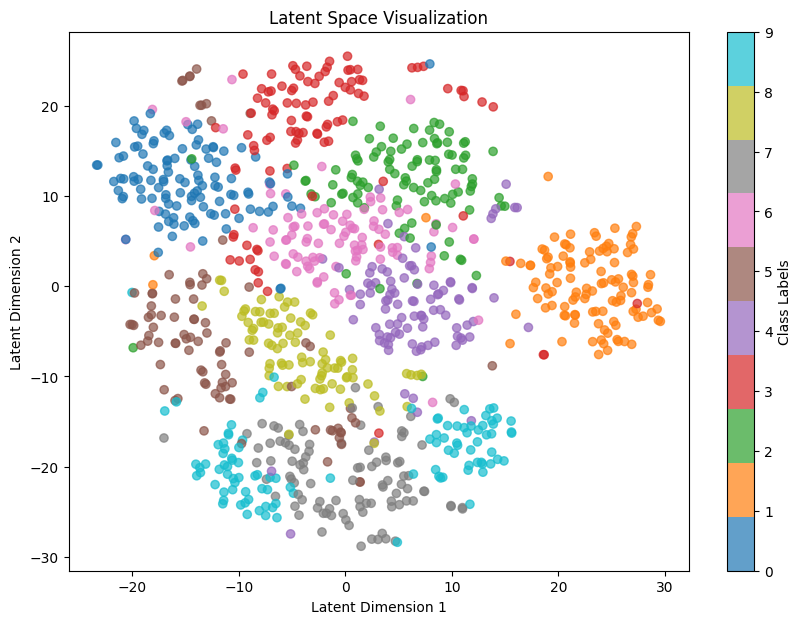

In [ ]:
visualize_latent_space(multi_view_vae, paired_loader, num_samples=1000, use_tsne=True, device=device)

Method for generating FMNIST data by using MNIST data.

In [ ]:
def generate_fmnist(model, paired_loader):
    model.eval()
    with torch.no_grad():
        x_mnist, x_fmnist, _ = next(iter(paired_loader))
        x_mnist = x_mnist.to(device)

        reconstructed_mnist, reconstructed_fashion, _, _, _ = model(x_mnist, None)

        # Plot the first 5 MNIST and FashionMNIST images and their reconstructions
        plt.figure(figsize=(12, 8))
        for i in range(5):
            # Original MNIST
            plt.subplot(4, 5, i + 1)
            plt.imshow(x_mnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Original MNIST")

            # Reconstructed MNIST
            plt.subplot(4, 5, i + 6)
            plt.imshow(reconstructed_mnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Reconstructed MNIST")

            # Original FashionMNIST
            plt.subplot(4, 5, i + 11)
            plt.imshow(x_fmnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Original FashionMNIST")

            # Reconstructed FashionMNIST
            plt.subplot(4, 5, i + 16)
            plt.imshow(reconstructed_fashion[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Reconstructed FashionMNIST")

        plt.tight_layout()
        plt.show()


Method for generating MNIST data using FMNIST data.

In [ ]:
def generate_mnist(model, paired_loader):
    model.eval()
    with torch.no_grad():
        x_mnist, x_fmnist, _ = next(iter(paired_loader))
        x_fmnist = x_fmnist.to(device)

        reconstructed_mnist, reconstructed_fashion, _, _, _ = model(None, x_fmnist)

        # Plot the first 5 MNIST and FashionMNIST images and their reconstructions
        plt.figure(figsize=(12, 8))
        for i in range(5):
            # Original MNIST
            plt.subplot(4, 5, i + 1)
            plt.imshow(x_mnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Original MNIST")

            # Reconstructed MNIST
            plt.subplot(4, 5, i + 6)
            plt.imshow(reconstructed_mnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Reconstructed MNIST")

            # Original FashionMNIST
            plt.subplot(4, 5, i + 11)
            plt.imshow(x_fmnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Original FashionMNIST")

            # Reconstructed FashionMNIST
            plt.subplot(4, 5, i + 16)
            plt.imshow(reconstructed_fashion[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')
            plt.title("Reconstructed FashionMNIST")

        plt.tight_layout()
        plt.show()


Using the methods from above, we are generating FMNIST and MNIST respectively and show their visualizations here.

Here FMNIST data is being generated by using MNIST data.

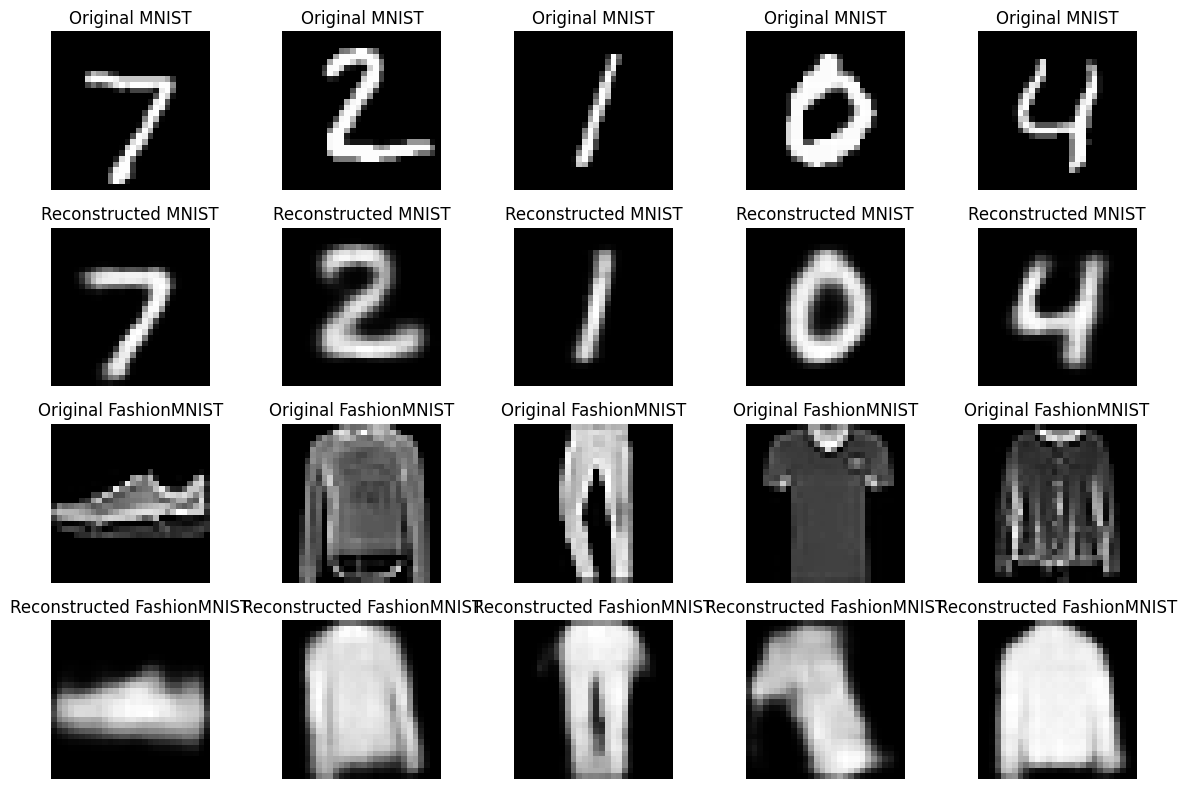

In [ ]:
generate_fmnist(multi_view_vae, paired_test_loader)

Here MNIST data is being generated by FMNIST data.

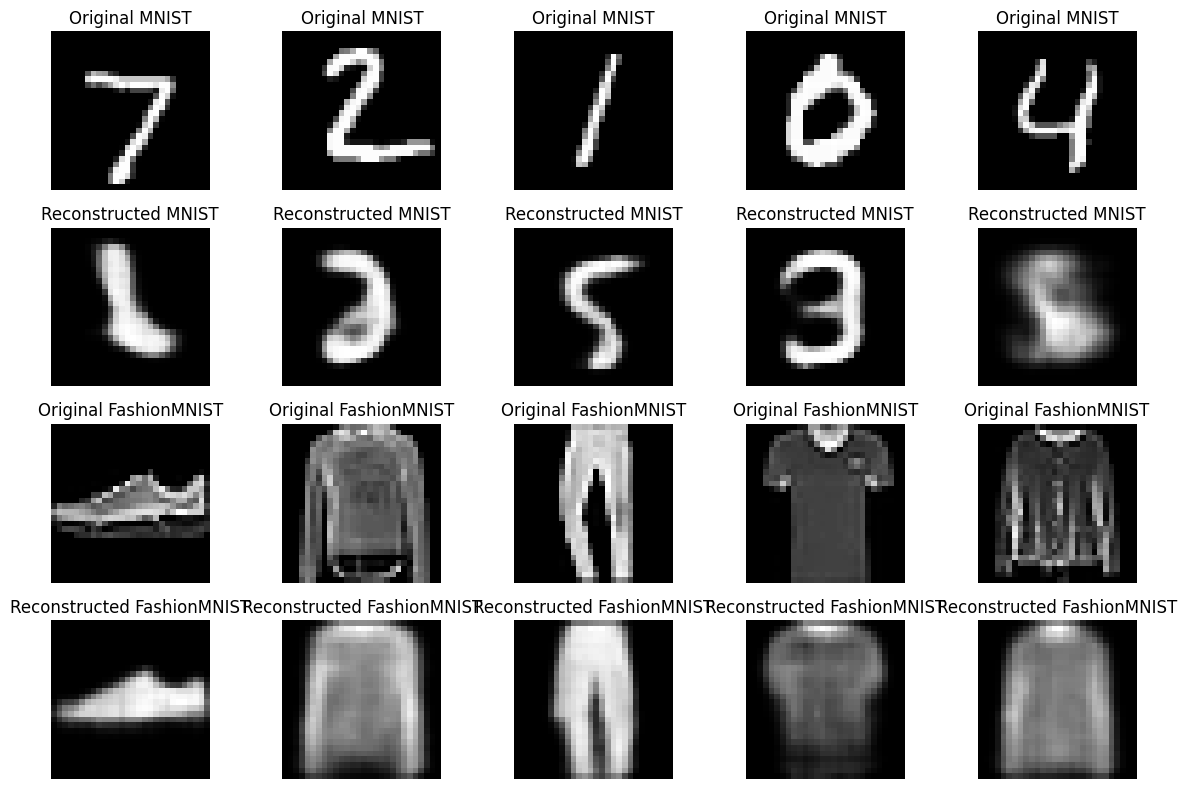

In [ ]:
generate_mnist(multi_view_vae, paired_test_loader)